# Sentiment Analysis in Spanish on a machine translated IMDB dataset

Let's take the classic IMDB movie review dataset (25,000 reviews), machine translate it to Spanish and create two basic sentiment analysis models. 

We will inspect also the most relevant words for each category (positive and negative reviews)

## Read the dataset

In [1]:
import pandas as pd
df = pd.read_csv('labeledTrainData.tsv', sep='\t', quoting=3)
df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


## Clean the data

In [3]:
import re

def clean_review(text):
    # Strip HTML tags-
    text = re.sub('<[^<]+?>', ' ', text)
 
    # Strip escaped quotes
    text = text.replace('\\"', '')
 
    # Strip quotes
    text = text.replace('"', '')

    return text

df['clean_review'] = df['review'].apply(clean_review)

## Machine translate the reviews

In [ ]:
#There are many translation APIs out there, I am using Translator

from translate import Translator
translator= Translator(to_lang="es")

df['review_es'] = df['review'].apply(lambda x: translator.translate(x))

#After it is finished, we save the new dataset

df.to_csv('labeledTrainData_en_es.tsv', sep='\t', quoting=3)

In [4]:
df = pd.read_csv('labeledTrainData_en_es.tsv', sep='\t', quoting=3)
df.head()

,Unnamed: 0,id,sentiment,cleaned_review,len,review_es
0,0,"""10962_3""",0,This movie is terrible but it has some good ef...,61,"Esta película es terrible, pero tiene algunos ..."
1,349,"""1553_10""",1,I havent seen that movie in 20 or more years b...,63,"No he visto esa película en 20 o más años, per..."
2,3,"""266_3""",0,You'd better choose Paul Verhoeven's even if y...,65,Será mejor que elijas el de Paul Verhoeven aun...
3,1,"""2331_1""",0,I wouldn't rent this one even on dollar rental...,68,No alquilaría este ni siquiera en una noche de...
4,4,"""4518_9""",1,Adrian Pasdar is excellent is this film. He ma...,70,Adrian Pasdar es excelente en esta película. E...


## Make lowercase, tokenize

In [6]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df['review_es'] = df['review_es'].str.lower()
df["tokens"] = df["review_es"].apply(tokenizer.tokenize)

df.head()

,Unnamed: 0,id,sentiment,cleaned_review,len,review_es,tokens
0,0,"""10962_3""",0,This movie is terrible but it has some good ef...,61,"esta película es terrible, pero tiene algunos ...","[esta, película, es, terrible, pero, tiene, al..."
1,349,"""1553_10""",1,I havent seen that movie in 20 or more years b...,63,"no he visto esa película en 20 o más años, per...","[no, he, visto, esa, película, en, 20, o, más,..."
2,3,"""266_3""",0,You'd better choose Paul Verhoeven's even if y...,65,será mejor que elijas el de paul verhoeven aun...,"[será, mejor, que, elijas, el, de, paul, verho..."
3,1,"""2331_1""",0,I wouldn't rent this one even on dollar rental...,68,no alquilaría este ni siquiera en una noche de...,"[no, alquilaría, este, ni, siquiera, en, una, ..."
4,4,"""4518_9""",1,Adrian Pasdar is excellent is this film. He ma...,70,adrian pasdar es excelente en esta película. e...,"[adrian, pasdar, es, excelente, en, esta, pelí..."


## Create a BOW classifier

Let's create simple embedding for each sentence and then use them to predict the relevant category. The simplest approach is to apply a logisitic regression on a Bag of Words model.

In [7]:
from sklearn.model_selection import train_test_split

list_corpus = df["review_es"].tolist()
list_labels = df["sentiment"].tolist()

# Shuffle the data and then split it, keeping 20% aside for testing
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

## Fitting the classifier

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)


LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [10]:
#Save the classifier

from joblib import dump
dump(clf, 'BOW_Sentiment_Classifier_es.joblib') 

['BOW_Sentiment_Classifier_es.joblib']

## Inspect the most important words

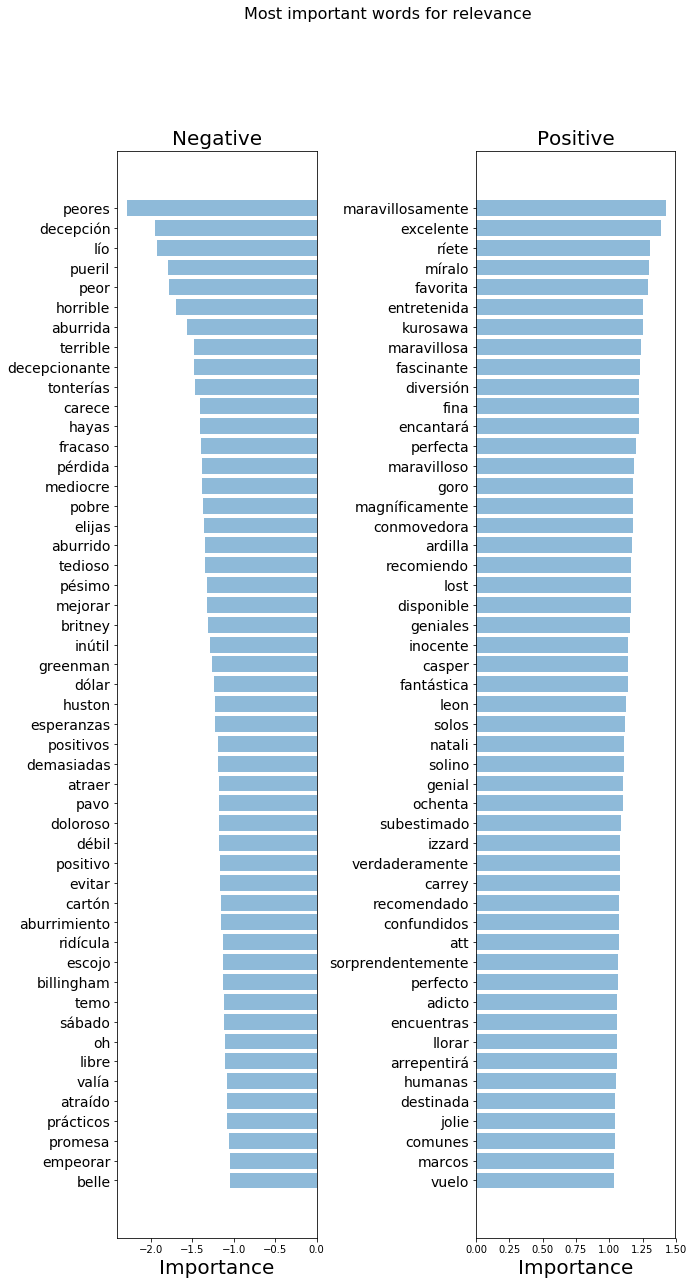

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 20))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
importance = get_most_important_features(count_vectorizer, clf, 50)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

We see that the model is picking up on some good words for each category, but we get unrelated words such as `korasawa`, `lost`, `carrey`, etc.

# TFIDF Vectorizer

Let's go beyond simple word counts and use a TFIDF model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
clf_tfidf = LogisticRegression(C=10.0, class_weight='balanced', solver='liblinear', 
                         multi_class='ovr', n_jobs=-1) #random_state=40
clf_tfidf.fit(X_train_tfidf, y_train)

C:\Users\agent\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
from joblib import dump
dump(clf_tfidf, 'TFIDF_Sentiment_Classifier_es.joblib') 

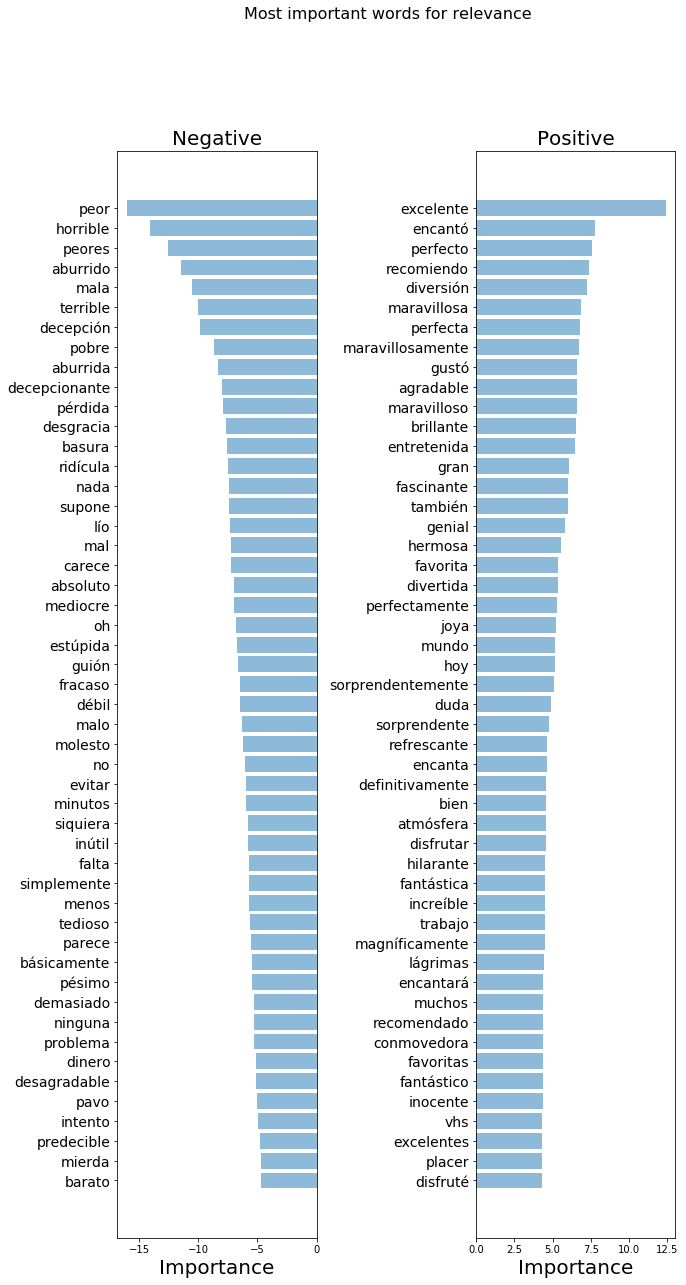

In [17]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 50)
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

This model is clearly better at picking up the words typically used in each category! 

The most important words for the "positive" category are `excelente`, `encantó`, `perfecto`, `recomiendo`, `diversión`, etc. While the most important words for the "negative" category are `peor`, `horrible`, `peores`, `aburrido`, `mala`, etc. 

## Let's predict a couple of real reviews

I head over to [El País](https://elpais.com) to get a couple of real movie reviews and see how our tfidf classifier is doing.

In [46]:
def predict(review):
    print(review+'\n')
    x = clf_tfidf.predict(tfidf_vectorizer.transform([review]))
    if x[0]==0:
        print ("This review is negative")
    if x[0]==1:
        print ("This review is positive")

        
review_a = 'Con un cargamento de clichés alrededor de cómo vemos al argentino (psicoanalista, locuaz, ligón, futbolero…) y cómo ven ellos al andaluz de pueblo, al llanito de Gibraltar y hasta la dicotomía entre taxistas y conductores de VTC, la película obliga a los intérpretes a lidiar con unos diálogos de poca o nula gracia. Y, a pesar de todo, de ahí sale indemne Dani Rovira, el único que clava casa frase, además de José Manuel Poga y Fernanda Orazi, magnífica actriz teatral en su debut en cine, capaces ambos de mostrar cualidades con dos papeles casi inexistentes y en apenas unas frases.'.lower()

predict(review_a)

con un cargamento de clichés alrededor de cómo vemos al argentino (psicoanalista, locuaz, ligón, futbolero…) y cómo ven ellos al andaluz de pueblo, al llanito de gibraltar y hasta la dicotomía entre taxistas y conductores de vtc, la película obliga a los intérpretes a lidiar con unos diálogos de poca o nula gracia. y, a pesar de todo, de ahí sale indemne dani rovira, el único que clava casa frase, además de josé manuel poga y fernanda orazi, magnífica actriz teatral en su debut en cine, capaces ambos de mostrar cualidades con dos papeles casi inexistentes y en apenas unas frases.

This review is negative


In [53]:
review_b = 'la historia se eleva gracias a la chispa de una parte de sus diálogos, al buen retrato de secundarios y a una serie de situaciones de efectiva comicidad. No es nada del otro mundo ni inventa nada, pero se ve agradablemente. Y, casi lo más importante en estos casos: ni se pasa de almíbar ni pretende dar la murga con los sentimientos, las conductas y los remordimientos.'.lower()

predict(review_b)

la historia se eleva gracias a la chispa de una parte de sus diálogos, al buen retrato de secundarios y a una serie de situaciones de efectiva comicidad. no es nada del otro mundo ni inventa nada, pero se ve agradablemente. y, casi lo más importante en estos casos: ni se pasa de almíbar ni pretende dar la murga con los sentimientos, las conductas y los remordimientos.

This review is positive


## Final experiment: train the models with bigrams and trigrams
So far we trained the models on single tokens, but can we also use phrases? Let's experiment with Gensim:

In [18]:
import gensim

# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['tokens'], min_count=3, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['tokens']], min_count=3, threshold=30)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def get_phrases(x):
    return trigram_mod[bigram_mod[x]]
df['phrases'] = df['tokens'].apply(get_phrases)

df.head()


C:\Users\agent\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\agent\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


,Unnamed: 0,id,sentiment,cleaned_review,len,review_es,tokens,phrases
0,0,"""10962_3""",0,This movie is terrible but it has some good ef...,61,"esta película es terrible, pero tiene algunos ...","[esta, película, es, terrible, pero, tiene, al...","[esta, película, es, terrible, pero, tiene, al..."
1,349,"""1553_10""",1,I havent seen that movie in 20 or more years b...,63,"no he visto esa película en 20 o más años, per...","[no, he, visto, esa, película, en, 20, o, más,...","[no, he_visto, esa, película, en, 20, o, más, ..."
2,3,"""266_3""",0,You'd better choose Paul Verhoeven's even if y...,65,será mejor que elijas el de paul verhoeven aun...,"[será, mejor, que, elijas, el, de, paul, verho...","[será, mejor, que, elijas, el, de, paul_verhoe..."
3,1,"""2331_1""",0,I wouldn't rent this one even on dollar rental...,68,no alquilaría este ni siquiera en una noche de...,"[no, alquilaría, este, ni, siquiera, en, una, ...","[no, alquilaría, este, ni_siquiera, en, una, n..."
4,4,"""4518_9""",1,Adrian Pasdar is excellent is this film. He ma...,70,adrian pasdar es excelente en esta película. e...,"[adrian, pasdar, es, excelente, en, esta, pelí...","[adrian_pasdar, es, excelente, en, esta, pelíc..."


## Important phrases from BOW model 

After training the models on the phrases, we get again the most important words from the simple bag of words model:

![alt text](https://i.imgur.com/1uD19Fq.png)

## Important phrases from TFIDF model 

Now let's get the most important phrases from the TFIDF model:

![](https://i.imgur.com/ONBPHii.png)

Here, the tfidf model picked up good phrases such as `me encantó`, `me gustó mucho` and `obra maestra` for the positive category, and it picked up phrases such as `gran decepción`, `peores películas`, and `sin gracia` for the negative category. 

The good thing about these simple models is that they allow to inspect features such as words and tokens. But in order to get a better accuracy, we need to keep learning and advancing to subjects such as embeddings and neural networks. 

References:

1) https://nlpforhackers.io/deep-learning-introduction/

2) https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb